# A Simple Convolutional AutoEncoder Implementation

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

import os
import random

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
# verify gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16900347925516805022
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6762114908
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10888173197631622159
physical_device_desc: "device: 0, name: GeForce GTX 980M, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [4]:
###### Constants ######
BATCH_SIZE=64
N_EPOCHS=10
PERCENT_VAL=0.2 # percentage of test data used for validation

# Autoencoder Parameters
LATENT_DIM = 10
INPUT_SHAPE = (28, 28, 1)

# Save/Load Model Constants
SAVE_PATH = os.path.join('..', 'models', 'conv_autoencoder')

LOADING_WEIGHTS = False
SAVING_WEIGHTS = False

TRAINING = True

In [5]:
###### Function Definitions ######
def normalize(images, labels):
    # Add channel
    images = tf.expand_dims(images, -1)
    images = tf.cast(images, tf.float32)
    images /= 255
    
    # Add channel
    labels = tf.expand_dims(labels, -1)
    labels = tf.cast(labels, tf.float32)
    labels /= 255
    
    return images, labels

def display_image(image):
    image = image if type(image) is np.ndarray else image.numpy()
    image = image.reshape((28,28))
    plt.figure(figsize=(2,2))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.colorbar()
    plt.grid(False)
    plt.show()

def display_images(images):
    plt.figure(figsize=(20,20))

    i = 0
    for image in images:
        image = image if type(image) is np.ndarray else image.numpy()
        image = image.reshape((28,28))
        plt.subplot(np.ceil(len(images)/5),5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
        i += 1
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
def split_data(data, percent):
    n = data.shape[0]
    indices = np.random.permutation(n)
    
    split = int(np.ceil(n * percent))
    return data[indices[split:]], data[indices[:split]]

def plot_history(history, metrics, figsize=(15,10)):
    plt.figure(figsize=figsize)

    for i, metrics in enumerate(metrics):
        plt.subplot(1,len(metrics),i+1)
        for metric in metrics:
            plt.plot(range(len(history.epoch)), history.history[metric], label=metric)
        plt.legend(loc='upper right')        

In [6]:
# 2nd elements are labels, which we don't need
(xtrain, _), (xtest, _) = tf.keras.datasets.fashion_mnist.load_data()

xtest, xval = split_data(xtest, PERCENT_VAL)

n_training = xtrain.shape[0]
n_test = xtest.shape[0]
n_val = xval.shape[0]

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, xtrain)).map(normalize).cache().repeat().shuffle(n_training//10).batch(BATCH_SIZE).prefetch(1)
val_ds = tf.data.Dataset.from_tensor_slices((xval, xval)).map(normalize).cache().repeat().batch(BATCH_SIZE).prefetch(1)
test_ds = tf.data.Dataset.from_tensor_slices((xtest, xtest)).map(normalize).batch(BATCH_SIZE)

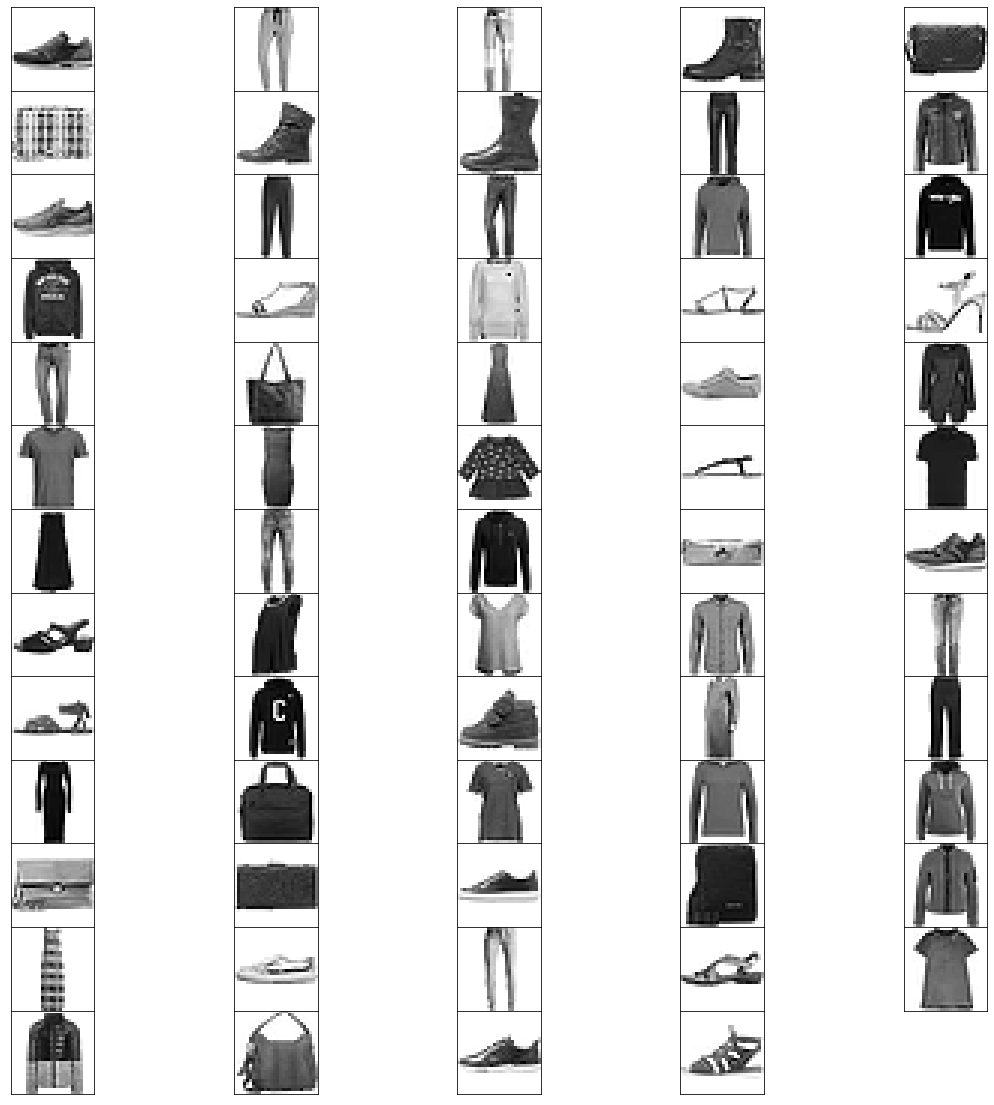

In [8]:
images, labels = next(iter(val_ds))
display_images(images)

In [9]:
# A Convolutional Auto-Encoder
class ConvAutoEncoder(tf.keras.Model):
    def __init__(self, latent_dim, input_shape):
        super(ConvAutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(name='encoder',
            layers = [
              tf.keras.layers.InputLayer(input_shape=(28,28,1), name='encoder/input'),
              tf.keras.layers.Conv2D(
                  filters=32, 
                  kernel_size=3, 
                  strides=(2, 2), 
                  padding='same', 
                  activation='relu', 
                  name='encoder/conv1'),
              tf.keras.layers.Conv2D(
                  filters=64, 
                  kernel_size=3, 
                  strides=(2, 2), 
                  padding='same', 
                  activation='relu', 
                  name='encoder/conv2'),
              tf.keras.layers.Flatten(name='encoder/flatten'),
              tf.keras.layers.Dense(latent_dim, name='encoder/bottleneck'),]
        )
        
        self.decoder = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=(latent_dim), name='decoder/input'),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu, name='decoder/dense1'),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32), name='decoder/reshape'),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding='same',
              activation='relu',
              name='decoder/deconv1'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding='same',
              activation='relu',
              name='decoder/deconv2'),
          tf.keras.layers.Conv2DTranspose(
              filters=1, 
              kernel_size=3, 
              strides=(1, 1),
              activation='sigmoid',
              padding='same', 
              name='decoder/deconv3'),])

    def call(self, inputs):
        z = self.encoder(inputs)
        x = self.decoder(z)
        return x
        
    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

In [16]:
model = ConvAutoEncoder(latent_dim=LATENT_DIM, input_shape=images.shape[1:])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

if LOADING_WEIGHTS:
    model.load_weights(SAVE_PATH)    

In [18]:
model.encoder.summary()
model.decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder/conv1 (Conv2D)       (None, 14, 14, 32)        320       
_________________________________________________________________
encoder/conv2 (Conv2D)       (None, 7, 7, 64)          18496     
_________________________________________________________________
encoder/flatten (Flatten)    (None, 3136)              0         
_________________________________________________________________
encoder/bottleneck (Dense)   (None, 10)                31370     
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder/dense1 (Dense)       (None, 1568)              17248     
_________________________________

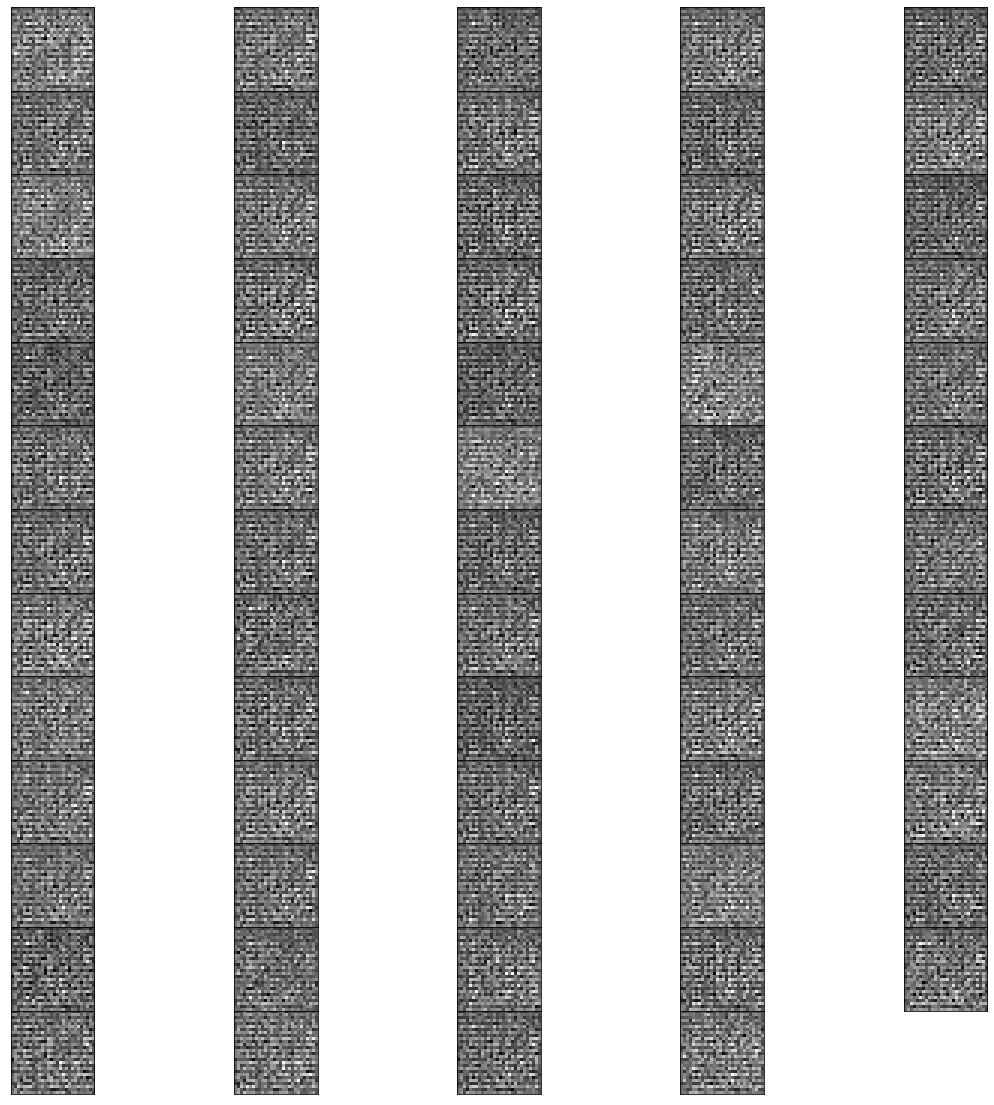

In [51]:
# visualize generation before training
zs = model.encoder(next(iter(val_ds)))
xs = model.decoder(zs)

display_images(xs)

Train for 938.0 steps, validate for 32.0 steps
Epoch 1/10
938/938 [==============================] - 12s 12ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 2/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 3/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 4/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 5/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 6/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0126 - 

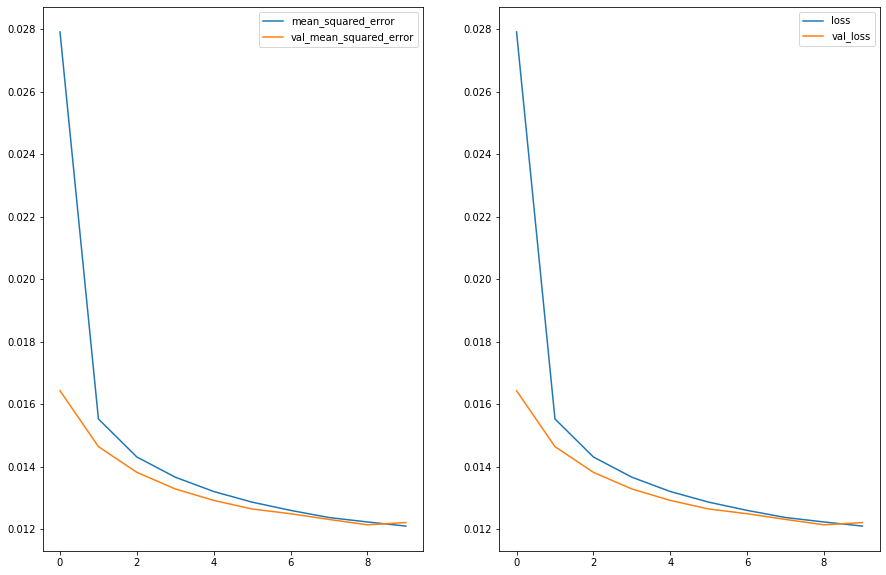

In [52]:
if TRAINING:
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(train_ds, 
                        callbacks=[early_stop_callback],
                        epochs=N_EPOCHS, 
                        steps_per_epoch=np.ceil(n_training/BATCH_SIZE), 
                        validation_data=val_ds, 
                        validation_steps=np.ceil(n_val/BATCH_SIZE))
    
    plot_history(history, 
             metrics=[('mean_squared_error', 'val_mean_squared_error'), ('loss', 'val_loss')])

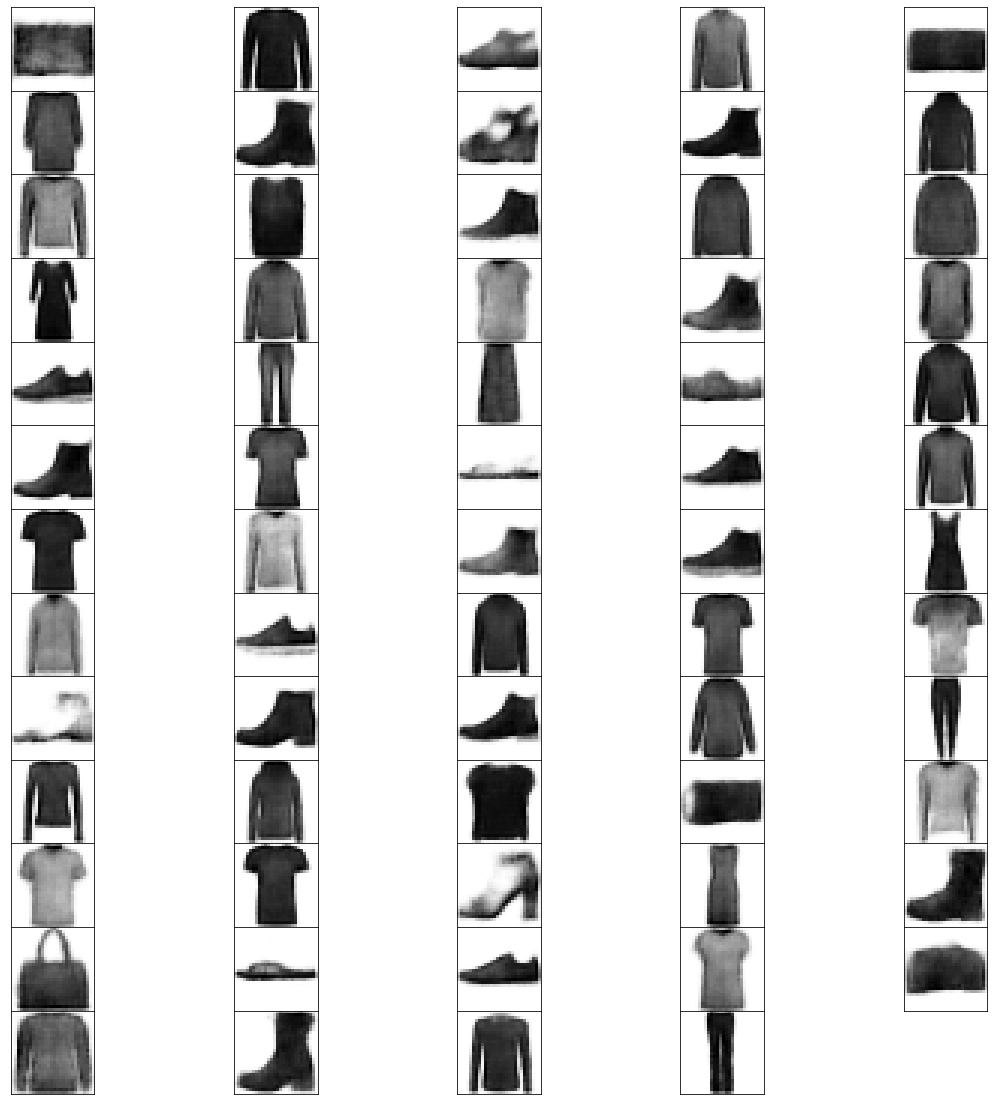

In [53]:
# visualize generation after training
zs = model.encoder(next(iter(val_ds)))
xs = model.decoder(zs)

display_images(xs)

In [54]:
# save model
if SAVING_WEIGHTS:
    try:
        model.save_weights(SAVE_PATH, save_format='tf')
    except Exception as e:
        print(e)

In [55]:
import scipy.spatial.distance

In [60]:
dists = []
for i, z in enumerate(zs):
  dists.append([i, scipy.spatial.distance.cosine(zs[0], z)])

dists = np.array(sorted(dists, key=lambda v: v[1]))

In [70]:
print(dists)

[[ 0.          0.        ]
 [ 4.          0.14543194]
 [59.          0.20493549]
 [48.          0.22568619]
 [60.          0.41590941]
 [ 7.          0.50296307]
 [10.          0.50775176]
 [ 2.          0.51500291]
 [ 1.          0.5405024 ]
 [23.          0.57438254]
 [20.          0.58365008]
 [62.          0.60963312]
 [57.          0.61458051]
 [24.          0.65003139]
 [50.          0.66918927]
 [33.          0.68110019]
 [47.          0.69099474]
 [41.          0.71304831]
 [32.          0.71381164]
 [43.          0.71393371]
 [28.          0.71531576]
 [29.          0.72279596]
 [49.          0.72626981]
 [14.          0.72727221]
 [16.          0.74164364]
 [36.          0.74561033]
 [52.          0.75336473]
 [31.          0.76633796]
 [42.          0.77101766]
 [56.          0.77356684]
 [ 5.          0.77534528]
 [40.          0.78618775]
 [ 3.          0.78818342]
 [ 8.          0.79334156]
 [45.          0.79737496]
 [39.          0.82659274]
 [55.          0.82867582]
 

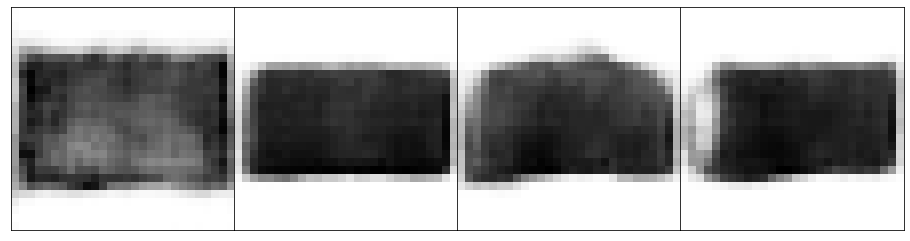

In [85]:
indices = dists[:,0][dists[:,1] < 0.3].astype(int)
display_images(xs.numpy()[indices])

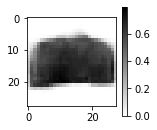

In [75]:
display_image(xs.numpy()[59])